### Input Redshift Cluster Endpoint and User
Please input your redshift cluster endpoint and existing user on that cluster.

In [12]:
REDSHIFT_ENDPOINT = 'democluster-5bd3e16b.cr5syyfjjfc0.us-east-1.redshift.amazonaws.com:5439/dev'
REDSHIFT_USER="demo"
REDSHIFT_IAM_ROLE='arn:aws:iam::709512860261:role/redshiftml-12-RedshiftMLIAMRole-709512860261'
S3_BUCKET='redshiftml-12-redshiftmlbucket-1mxb3ll9jpxz9'

### Setup Run SQL function using Redshift Data API to get SQL query output directly into pandas dataframe
In this step, we are creating function run_sql, which we will use to get SQL query output directly into pandas dataframe. We will also use this function to run DDL statements

In [3]:

import boto3
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

session = boto3.session.Session()
region = session.region_name


def run_sql(sql_text):
    client = boto3.client("redshift-data")
    res = client.execute_statement(Database=REDSHIFT_ENDPOINT.split('/')[1], DbUser=REDSHIFT_USER, Sql=sql_text,
                                   ClusterIdentifier=REDSHIFT_ENDPOINT.split('.')[0])
    query_id = res["Id"]
    done = False
    while not done:
        time.sleep(1)
        status_description = client.describe_statement(Id=query_id)
        status = status_description["Status"]
        if status == "FAILED":
            raise Exception('SQL query failed:' + query_id + ": " + status_description["Error"])
        elif status == "FINISHED":
            if status_description['ResultRows']>0:
                results = client.get_statement_result(Id=query_id)
                column_labels = []
                for i in range(len(results["ColumnMetadata"])): column_labels.append(results["ColumnMetadata"][i]['label'])
                records = []
                for record in results.get('Records'):
                    records.append([list(rec.values())[0] for rec in record])
                df = pd.DataFrame(np.array(records), columns=column_labels)
                return df
            else:
                
                return query_id 
 

## Data Preparation Script
Data preparation script to be run on Redshift

In [4]:
setup_script = """
DROP TABLE IF EXISTS ridership CASCADE;
DROP TABLE IF EXISTS weather CASCADE;
DROP TABLE IF EXISTS holiday CASCADE;
DROP TABLE IF EXISTS trip_data CASCADE;

CREATE TABLE IF NOT EXISTS ridership
( trip_id               INT
, trip_duration_seconds INT
, trip_start_time       timestamp
, trip_stop_time        timestamp
, from_station_name     VARCHAR(50)
, to_station_name       VARCHAR(50)
, from_station_id       SMALLINT
, to_station_id         SMALLINT
, user_type             VARCHAR(20));

CREATE TABLE IF NOT EXISTS weather
( longitude_x         DECIMAL(5,2)
, latitude_y          DECIMAL(5,2)
, station_name        VARCHAR(20)
, climate_id          BIGINT
, datetime_utc        TIMESTAMP
, weather_year        SMALLINT
, weather_month       SMALLINT
, weather_day         SMALLINT
, time_utc            VARCHAR(5)
, temp_c              DECIMAL(5,2)
, temp_flag           VARCHAR(1)
, dew_point_temp_c    DECIMAL(5,2)
, dew_point_temp_flag VARCHAR(1)
, rel_hum             SMALLINT
, rel_hum_flag        VARCHAR(1)
, precip_amount_mm    DECIMAL(5,2)
, precip_amount_flag  VARCHAR(1)
, wind_dir_10s_deg    VARCHAR(10)
, wind_dir_flag       VARCHAR(1)
, wind_spd_kmh        VARCHAR(10)
, wind_spd_flag       VARCHAR(1)
, visibility_km       VARCHAR(10)
, visibility_flag     VARCHAR(1)
, stn_press_kpa       DECIMAL(5,2)
, stn_press_flag      VARCHAR(1)
, hmdx                SMALLINT
, hmdx_flag           VARCHAR(1)
, wind_chill          VARCHAR(10)
, wind_chill_flag     VARCHAR(1)
, weather             VARCHAR(10));

CREATE TABLE IF NOT EXISTS holiday
( holiday_date  DATE
, description VARCHAR(100));


COPY ridership FROM 
's3://redshift-ml-bikesharing-data/bike-sharing-data/ridership/'
IAM_ROLE '{}'
FORMAT csv IGNOREHEADER 1 DATEFORMAT 'auto' TIMEFORMAT 'auto' REGION 'us-west-2' gzip;

COPY weather FROM
's3://redshift-ml-bikesharing-data/bike-sharing-data/weather/'
IAM_ROLE '{}'
FORMAT csv IGNOREHEADER 1 DATEFORMAT 'auto' TIMEFORMAT 'auto' REGION 'us-west-2' gzip;

COPY holiday FROM
's3://redshift-ml-bikesharing-data/bike-sharing-data/holiday/'
IAM_ROLE '{}'
FORMAT csv IGNOREHEADER 1 DATEFORMAT 'auto' TIMEFORMAT 'auto' REGION 'us-west-2' gzip;

CREATE OR REPLACE VIEW ridership_view AS
SELECT
    trip_time
    , trip_count
    , TO_CHAR(trip_time,'hh24') ::INT trip_hour
    , TO_CHAR(trip_time, 'dd') :: INT trip_day
    , TO_CHAR(trip_time, 'mm') :: INT trip_month
    , TO_CHAR(trip_time, 'yy') :: INT trip_year
    , TO_CHAR(trip_time, 'q') :: INT trip_quarter
    , TO_CHAR(trip_time, 'w') :: INT trip_month_week
    , TO_CHAR(trip_time, 'd') :: INT trip_week_day
FROM  
    (SELECT  
         CASE
           WHEN TRUNC(r.trip_start_time) < '2017-07-01'::DATE
           THEN CONVERT_TIMEZONE('US/Eastern', DATE_TRUNC('hour',r.trip_start_time))
           ELSE DATE_TRUNC('hour',r.trip_start_time)
         END trip_time
         , COUNT(1) trip_count
     FROM    
         ridership r
     WHERE    r.trip_duration_seconds BETWEEN 60 AND 60 * 60 * 24
     GROUP BY
         1);

CREATE OR REPLACE VIEW weather_view AS
SELECT  
    CONVERT_TIMEZONE('US/Eastern', 
      DATE_TRUNC('hour',datetime_utc)) daytime
    , ROUND(AVG(temp_c)) temp_c
    , ROUND(AVG(precip_amount_mm)) precip_amount_mm
FROM weather
GROUP BY 1;

DROP TABLE IF EXISTS trip_data;
CREATE TABLE trip_data AS 
SELECT         
   r.trip_time
  ,r.trip_count
  ,r.trip_hour
  ,r.trip_day
  ,r.trip_month
  ,r.trip_year
  ,r.trip_quarter
  ,r.trip_month_week
  ,r.trip_week_day
  ,w.temp_c
  ,w.precip_amount_mm
  ,CASE
      WHEN h.holiday_date IS NOT NULL
      THEN 1
      WHEN TO_CHAR(r.trip_time,'D')::INT IN (1,7)
      THEN 1
      ELSE 0
    END is_holiday
  , ROW_NUMBER() OVER (ORDER BY RANDOM()) serial_number
FROM           
  ridership_view r
JOIN            weather_view w
  ON ( r.trip_time = w.daytime )
LEFT OUTER JOIN holiday h
  ON ( TRUNC(r.trip_time) = h.holiday_date );

"""

### Run data preparation script in Redshift

In [6]:
Sql_Commands=setup_script.split(";")
for sql_text in Sql_Commands[:-1]:
    print("Executing:", sql_text.format(REDSHIFT_IAM_ROLE))
    print("Queryid:",run_sql(sql_text.format(REDSHIFT_IAM_ROLE)))
    

Executing: 
DROP TABLE IF EXISTS ridership CASCADE
Queryid: 4523a0db-39b7-4f43-b1ab-5501b1e6d000:FINISHED
Executing: 
DROP TABLE IF EXISTS weather CASCADE
Queryid: 1a6e139e-2656-4c8e-ae3f-4d6eb81699f2:FINISHED
Executing: 
DROP TABLE IF EXISTS holiday CASCADE
Queryid: c075d955-35c6-41d3-836b-84b593ccc778:FINISHED
Executing: 
DROP TABLE IF EXISTS trip_data CASCADE
Queryid: 5a9afd55-ef5d-45c1-80d1-ccb473cb7590:FINISHED
Executing: 

CREATE TABLE IF NOT EXISTS ridership
( trip_id               INT
, trip_duration_seconds INT
, trip_start_time       timestamp
, trip_stop_time        timestamp
, from_station_name     VARCHAR(50)
, to_station_name       VARCHAR(50)
, from_station_id       SMALLINT
, to_station_id         SMALLINT
, user_type             VARCHAR(20))
Queryid: 3e79bf50-6c95-4f2a-b7c5-0c80e02475ef:FINISHED
Executing: 

CREATE TABLE IF NOT EXISTS weather
( longitude_x         DECIMAL(5,2)
, latitude_y          DECIMAL(5,2)
, station_name        VARCHAR(20)
, climate_id          BI

### Read SQL output with Pandas Dataframe

In [7]:
df = run_sql("select trip_count, trip_time from trip_data");
df.head(10)

,trip_count,trip_time
0,449,2017-09-03 17:00:00
1,15,2018-05-07 01:00:00
2,606,2018-06-21 09:00:00
3,346,2018-05-09 12:00:00
4,8,2017-01-15 02:00:00
5,95,2017-08-27 08:00:00
6,95,2018-03-26 21:00:00
7,88,2018-09-28 21:00:00
8,466,2018-08-25 19:00:00
9,17,2017-04-22 07:00:00


In [6]:
df.describe()

,trip_count,trip_time
count,17306,17306
unique,1066,17306
top,2,2017-11-28 20:00:00.0
freq,239,1


### Visualize data using matplotlib

Text(0.5, 1.0, 'trip count histogram')

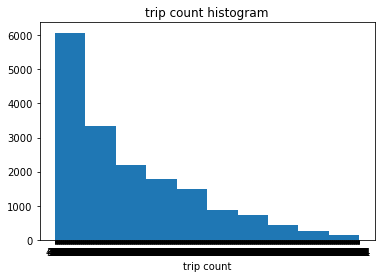

In [8]:
plt.hist(df.trip_count)
plt.xlabel('trip count')
plt.title('trip count histogram')

In [10]:
df = run_sql("select round(trip_count/100) trip_count, trip_hour from trip_data");
df.head(10)


,trip_count,trip_hour
0,1.0,16.0
1,2.0,17.0
2,3.0,18.0
3,0.0,15.0
4,0.0,21.0
5,4.0,13.0
6,0.0,1.0
7,1.0,10.0
8,0.0,2.0
9,1.0,23.0


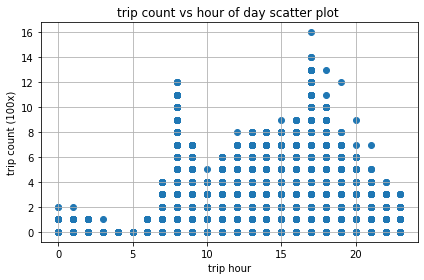

In [11]:
plt.scatter(df.trip_hour,df.trip_count)
plt.ylabel('trip count (100x)')
plt.xlabel('trip hour')
plt.title('trip count vs hour of day scatter plot ')
plt.grid(True)
plt.tight_layout()

### Run Create Model statement to create a new ML model with REdshift ML

In [14]:
create_model_command = """
CREATE MODEL predict_rental_count 
FROM (SELECT
 trip_count,trip_hour,trip_day,trip_month,trip_year,trip_quarter,
 trip_month_week, trip_week_day, temp_c, precip_amount_mm, is_holiday
FROM trip_data)
TARGET trip_count
FUNCTION predict_rental_count
IAM_ROLE '{}'
PROBLEM_TYPE regression
OBJECTIVE 'mse'
SETTINGS (s3_bucket '{}')
"""



In [16]:
run_sql( create_model_command.format(REDSHIFT_IAM_ROLE,S3_BUCKET))


'b41735d3-8e7d-4c86-abb7-f0b8ef07fa1d:FINISHED'

### View Model Progress 

In [19]:
df = run_sql("SHOW MODEL predict_rental_count")
df

,Key,Value
0,Model Name,predict_rental_count
1,Schema Name,public
2,Owner,demo
3,Creation Time,"Thu, 05.08.2021 21:50:55"
4,Model State,TRAINING
5,,
6,TRAINING DATA:,
7,Query,"SELECT TRIP_COUNT,TRIP_HOUR,TRIP_DAY,TRIP_MONT..."
8,,FROM TRIP_DATA
9,Target Column,TRIP_COUNT


### Run Prediction and compare actual vs predicted


In [18]:
df = run_sql("""
SELECT trip_time, actual_count, predicted_count, ( actual_count - predicted_count ) difference
FROM  
(SELECT
 trip_time
,trip_count AS actual_count
,PREDICT_RENTAL_COUNT (trip_hour, trip_day, trip_month, trip_year, trip_quarter, trip_month_week, trip_week_day, temp_c, precip_amount_mm, is_holiday) predicted_count
FROM trip_data
) LIMIT 5;
""")

df


Exception: SQL query failed:f026d0e4-1544-4b5b-9658-b6c331aec601: ERROR: The ML model is not ready, check STV_ML_MODEL_INFO for its status.
  Detail: 
  -----------------------------------------------
  error:  The ML model is not ready, check STV_ML_MODEL_INFO for its status.
  code:      28008
  context:   
  query:     21736
  location:  cg_expr_fn_builder.cpp:2724
  process:   padbmaster [pid=25303]
  -----------------------------------------------
